## Preprocessing and Transfer Learning

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trainSet, info = tfds.load(name='oxford_flowers102', split='train', as_supervised=True, with_info=True)
validSet = tfds.load(name='oxford_flowers102', split='validation', as_supervised=True)
testSet = tfds.load(name='oxford_flowers102', split='test', as_supervised=True)

In [3]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(info.features['label'].num_classes,activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input,outputs=output)
for layer in base_model.layers:
    layer.trainable=False

In [4]:
def preprocess(image,label):
    resized_image = tf.image.resize_with_pad(image, 299, 299)
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [5]:
trainPipe = trainSet.map(preprocess,num_parallel_calls=32).batch(8).prefetch(1)
validPipe = validSet.map(preprocess,num_parallel_calls=32).batch(8).prefetch(1)
testPipe = testSet.map(preprocess,num_parallel_calls=32).batch(8).prefetch(1)

step_size = 0.2
optimizer = keras.optimizers.SGD(learning_rate=step_size)

checkpoint_cb = keras.callbacks.ModelCheckpoint('flowersModel-freezed.h5',save_best_only=True)
earlyStop_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])
model.fit(trainPipe,validation_data=validPipe,epochs=5,callbacks=[checkpoint_cb,earlyStop_cb])

Epoch 1/5
128/128 [==============================] - 38s 300ms/step - loss: 3.7660 - accuracy: 0.1598 - val_loss: 3.7283 - val_accuracy: 0.0971
Epoch 2/5
128/128 [==============================] - 37s 289ms/step - loss: 1.7062 - accuracy: 0.6559 - val_loss: 2.2030 - val_accuracy: 0.3775
Epoch 3/5
128/128 [==============================] - 36s 282ms/step - loss: 0.9327 - accuracy: 0.8559 - val_loss: 1.5402 - val_accuracy: 0.6098
Epoch 4/5
128/128 [==============================] - 36s 282ms/step - loss: 0.5952 - accuracy: 0.9480 - val_loss: 1.3101 - val_accuracy: 0.6853
Epoch 5/5
128/128 [==============================] - 37s 289ms/step - loss: 0.4159 - accuracy: 0.9755 - val_loss: 1.1941 - val_accuracy: 0.7196


In [6]:
for layer in base_model.layers:
    layer.trainable=True

ss = 0.1
checkpoint_cb = keras.callbacks.ModelCheckpoint('flowersModel.h5',save_best_only=True)
earlyStop_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
optimizer = keras.optimizers.SGD(learning_rate=ss)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])
model.fit(trainPipe,validation_data=validPipe,epochs=10,callbacks=[checkpoint_cb,earlyStop_cb])

Epoch 1/10
  2/128 [..............................] - ETA: 39s - loss: 2.1678 - accuracy: 0.4375WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1560s vs `on_train_batch_end` time: 0.4733s). Check your callbacks.


128/128 [==============================] - 102s 795ms/step - loss: 0.9999 - accuracy: 0.7490 - val_loss: 2.8560 - val_accuracy: 0.3971
Epoch 2/10
128/128 [==============================] - 101s 786ms/step - loss: 0.0915 - accuracy: 0.9863 - val_loss: 0.5423 - val_accuracy: 0.8598
Epoch 3/10
128/128 [==============================] - 100s 780ms/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.3560 - val_accuracy: 0.9029
Epoch 4/10
128/128 [==============================] - 100s 779ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.3482 - val_accuracy: 0.9069
Epoch 5/10
128/128 [==============================] - 100s 779ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.3426 - val_accuracy: 0.9088
Epoch 6/10
128/128 [==============================] - 99s 774ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.3387 - val_accuracy: 0.9108
Epoch 7/10
128/128 [==============================] - 100s 778ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.3358 - val_accurac

In [7]:
top1err = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=[top1err])
model.evaluate(testPipe)

769/769 [==============================] - 108s 140ms/step - loss: 0.3920 - sparse_top_k_categorical_accuracy: 0.8964


[0.3920345902442932, 0.8964059352874756]

In [8]:
top5err = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=[top5err])
model.evaluate(testPipe)

769/769 [==============================] - 112s 145ms/step - loss: 0.3920 - sparse_top_k_categorical_accuracy: 0.9758


[0.3920345902442932, 0.9757684469223022]

In [9]:
top10err = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=[top10err])
model.evaluate(testPipe)

769/769 [==============================] - 113s 147ms/step - loss: 0.3920 - sparse_top_k_categorical_accuracy: 0.9891


[0.3920345902442932, 0.9891039133071899]

## Unsupervised Learning

In [10]:
new_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(new_model.output)
new_model = keras.models.Model(inputs=new_model.input,outputs=avg)

In [11]:
testSet,info = tfds.load(name='oxford_flowers102', split='test', as_supervised=True, with_info=True)

def preprocess(image,label):
    resized_image = tf.image.resize_with_pad(image, 299, 299)
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

testPipe = testSet.map(preprocess,num_parallel_calls=32).batch(8)

In [12]:
features = new_model.predict(testPipe)

In [13]:
from sklearn.decomposition import PCA
num_dims = 102
explained_variance_ratio = []
for dim in np.linspace(1,num_dims,num_dims,dtype=int):
    pca = PCA(n_components = dim)
    transform = pca.fit_transform(features)
    explained_variance_ratio.append(pca.explained_variance_ratio_.sum())

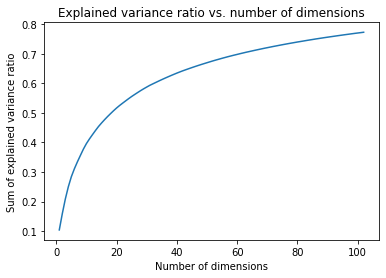

In [14]:
fig = plt.figure()
plt.plot(np.linspace(1,num_dims,num_dims), explained_variance_ratio)
plt.xlabel('Number of dimensions')
plt.ylabel('Sum of explained variance ratio')
plt.title('Explained variance ratio vs. number of dimensions')
fig.savefig('explainedVariancePlot.png', bbox_inches='tight')

In [ ]:
new_model.summary()